In [1]:
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from utils import *
from tgp_research_quantitative_tools.optionpricing.ClosedForm.Black import SpreadOptionTwoAssets

###  First, we set the details of our HRCO

In [2]:
as_of = dt.datetime(2024, 2, 10) # date of reference fwd curve

start_simulation_date = dt.datetime(2024, 5, 25)
end_simulation_date = dt.datetime(2024, 8, 10)

start_contract_date = dt.datetime(2024, 6, 1)
end_contract_date = dt.datetime(2024, 8, 30)

power_market = "ERCOTHOUHUB"
gas_market = "HH_gas"

granularity = "daily"
methodology = "spot" # we use spot simulations since we need the 1-day ahead prices

heat_rate = 12 # MMBtu/MWh
gas_adder = 0.05 # $/MMBtu
start_charge = 700 # MMBtu (to be multiplied by the gas price)
VOM = 0.8 # $/MWh
daily_volume = 24 * 200 # MWh

energy_payment_delay = 20 # days from delivery to payment date
energy_payment_grouped_monthly = True # True if Energy Payments are group by month, False otherwise 

monthly_option_premium = 2590000
# We assume that option premiums are only paid while the contract is alive, but this can be changed
option_premium_payment_dates = pd.date_range(start=start_contract_date, end=end_contract_date, freq='MS')

# Note that we simplify the pricing by assuming that the buyer of the HRCO only books slots of 24h each day.
# This follows the reasoning that if the MtM is positive, he will make the most out of it by booking the maximum daily amount available.

nb_scenarios = 5
interest_rate = 0.0425

### Simulate spot prices for gas and power

In [3]:
simulation = simulate_fwd_prices(
    [power_market, gas_market], 
    start_simulation_date,
    end_simulation_date, 
    methodology,
    granularity, 
    as_of=as_of, 
    start_fwd_date=start_contract_date,
    nb_simulation=nb_scenarios,
)

c:\Users\AMIREL\Desktop\Research HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\two_factor_model.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp2 = pd.concat([df_temp, df_temp.shift(1)], axis=1).fillna(method='bfill')
c:\Users\AMIREL\Desktop\Research HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\two_factor_model.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp2 = pd.concat([df_temp, df_temp.shift(1)], axis=1).fillna(method='bfill')
c:\Users\AMIREL\Desktop\Research HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\two_factor_model.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


Time for solve_minimization_problem : 0.1 seconds


c:\Users\AMIREL\Desktop\Research HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\two_factor_model.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp2 = pd.concat([df_temp, df_temp.shift(1)], axis=1).fillna(method='bfill')
c:\Users\AMIREL\Desktop\Research HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\two_factor_model.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp2 = pd.concat([df_temp, df_temp.shift(1)], axis=1).fillna(method='bfill')
c:\Users\AMIREL\Desktop\Research HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\two_factor_model.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.288551749407879e-05
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9
Time for solve_minimization_problem : 0.05 seconds
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0032772687396059015
            Iterations: 51
            Function evaluations: 1019
            Gradient evaluations: 51
Time for solve_minimization_problem : 0.12 seconds


c:\Users\AMIREL\Desktop\Research HRCO\venv\lib\site-packages\tgp_research_quantitative_tools\optionpricing\MonteCarlo\DiffusionProcess.py:51: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.hourly_index_date_range = pd.date_range(self.start_date, self.end_date + dt.timedelta(days=1),


Time for compute_daily_gas_shaping_from_monthly_assessments : 0.01 seconds


## HRCO Pricing

Build some dfs that we need

In [4]:
simulation_dates = pd.date_range(start=start_simulation_date, end=end_simulation_date, freq='D')
maturity_dates = simulation_dates.to_frame()[start_contract_date:end_contract_date].index

power_prices_df = pd.DataFrame(simulation[power_market].values, index=simulation_dates)
gas_prices_df = pd.DataFrame(simulation[gas_market].values, index=simulation_dates)

We need to compute *annualized* correlations and volatilities, we will use the average sample variance and correlations from the simulations

In [5]:
# Volatilities and correlations are computed on the relative daily returns
power_returns_df = power_prices_df.pct_change().dropna()
gas_returns_df = gas_prices_df.pct_change().dropna()

# Compute daily volatilities and annualize them (we use natural years instead of business years since commodities are traded OTC every day)
power_vol = power_returns_df.std(axis=0).mean() * np.sqrt(365.25)
gas_vol = gas_returns_df.std(axis=0).mean() * np.sqrt(365.25)

power_gas_corr = 0

for i in range(nb_scenarios):
    power_gas_corr += np.corrcoef(power_returns_df[i], gas_returns_df[i])[0,1]
    
# Divide to get the average
power_gas_corr /= nb_scenarios

Now we set the coefficients of the HRCO to make it fit the Two-Asset spread option framework. For this, recall that the payoff of our HRCO follows:

$$
P =  \max \bigr\{DV \times S_e - e^{-r \delta_t} \times[DV \times \{HR \times (S_g + GA) + VOM\} + SC \times (S_g + GA)], 0 \bigr\}
$$

Where
- $DV$ is the daily volume (in MWh),
- $S_e$ is the 1-day ahead (spot) electricity price for 24 hours of delivery (in $/MWh),
- $S_g$ is the 1-day ahead (spot) gas price for 24 hours of delivery (in $/MMBtu),
- $\delta_t$ is the time difference between the Energy Payment date and the delivery date (in years), 
- $HR$ is the Heat Ratio (in MMBTu/MWh),
- $GA$ is the gas adder (in $/MMBtu),
- $VOM$ is the Variable Operational and Maintenance costs (in $/MWh),
- $SC$ is the Start Cost (in MMBtu).

Linking to HRCO terminology, we have that

- $(HR \times (S_g + GA) + VOM)$ is the Energy Payment,
- $e^{-r \delta_t} \times (HR \times (S_g + GA) + VOM)$ is the Energy Payment adjusted by the fact that the payment is made $\delta_t$ days after delivery,
- $S_e - e^{-r \delta_t} \times (HR \times (S_g + GA) + VOM)$ is the Spark Spread.

Moreover, a general payoff profile for a Two-Asset Spread Option is of the form:

$$
P = \max \bigr[\alpha \times S_e - \beta \times S_g - K, 0 \bigr]
$$

And therefore, linking both, we have:

$$
\alpha = DV, \\
\beta = e^{-r \delta_t} \times (DV \times HR + SC), \\ 
K = e^{-r \delta_t} \times [DV \times (HR \times GA + VOM) + SC \times GA]
$$

In [6]:
simulation_prices_list = []
simulation_spark_spreads_list = []
for i, simul_date in enumerate(simulation_dates):
    
    maturity_prices_list = []
    maturity_spark_spreads_list = []
    for j, maturity_date in enumerate(maturity_dates):
        
        # Compute delta_t in years (time difference between the Energy Payment date and delivery), taking into account the 1-day delivery delay
        if energy_payment_grouped_monthly:
            days_to_end_month = ((maturity_date + pd.offsets.MonthEnd(0)) - maturity_date).days
            delta_t = (days_to_end_month + energy_payment_delay - 1) / 365.25
        else:
            delta_t = (energy_payment_delay - 1) / 365.25
            
        # Compute time to expiry of the current option (in years), taking into account the 1-day delivery delay
        time_to_expiry = ((maturity_date - simul_date).days + 1) / 365.25
        
        # Compute the coefficients for the HRCO option
        # Note that, since delta_t is not constant but rather depends on the day of the month, these coefficients need to be dinamically computed for each option
        alpha = daily_volume
        beta = np.exp(-interest_rate * delta_t) * (daily_volume * heat_rate + start_charge)
        strike = np.exp(-interest_rate * delta_t) * (daily_volume * (heat_rate * gas_adder + VOM) + start_charge * gas_adder)
        
        # If we are after maturity (we have added 1 to time_to_expiry), we set the prices to 0
        if time_to_expiry <= 0:
            maturity_prices_list.append([0]*nb_scenarios)
            maturity_spark_spreads_list.append([0]*nb_scenarios)
            continue
        
        scenario_prices_list = []
        scenario_spark_spreads_list = []
        
        for k in range(nb_scenarios):
            
            # Load the power and gas prices
            power_price = power_prices_df.iloc[i, k]
            gas_price = gas_prices_df.iloc[i, k]
            
            # Add the spark spread to the list
            scenario_spark_spreads_list.append(alpha * power_price - beta * gas_price - strike)
            
            # print(power_price, gas_price, alpha, beta, strike, time_to_expiry, power_vol, gas_vol, power_gas_corr, interest_rate)

            # Create the option instance
            opt = SpreadOptionTwoAssets(
                type = "Call",
                underlying1 = power_price,
                underlying2 = gas_price,
                coef1 = alpha,
                coef2 = beta,
                strike = strike,
                time_to_expiry = time_to_expiry,
                volatility1 = power_vol, 
                volatility2 = gas_vol,
                correlation = power_gas_corr,
                rate = interest_rate
            )
            
            scenario_prices_list.append(opt.price())
            
        maturity_prices_list.append(scenario_prices_list)
        maturity_spark_spreads_list.append(scenario_spark_spreads_list)
            
    simulation_prices_list.append(maturity_prices_list)       
    simulation_spark_spreads_list.append(maturity_spark_spreads_list)   
    
option_prices = np.array(simulation_prices_list)
spark_spreads = np.array(simulation_spark_spreads_list)

In [7]:
pd.DataFrame(spark_spreads[:, :, 0], index=simulation_dates, columns=maturity_dates).iloc[0:30]

,2024-06-01,2024-06-02,2024-06-03,2024-06-04,2024-06-05,2024-06-06,2024-06-07,2024-06-08,2024-06-09,2024-06-10,...,2024-08-01,2024-08-02,2024-08-03,2024-08-04,2024-08-05,2024-08-06,2024-08-07,2024-08-08,2024-08-09,2024-08-10
2024-05-25,39605.884722,39591.883732,39577.881112,39563.876863,39549.870985,39535.863476,39521.854338,39507.843569,39493.831171,39479.817141,...,39619.884083,39605.884722,39591.883732,39577.881112,39563.876863,39549.870985,39535.863476,39521.854338,39507.843569,39493.831171
2024-05-26,45427.635959,45413.742934,45399.848293,45385.952034,45372.054159,45358.154667,45344.253557,45330.350829,45316.446484,45302.540520,...,45441.527367,45427.635959,45413.742934,45399.848293,45385.952034,45372.054159,45358.154667,45344.253557,45330.350829,45316.446484
2024-05-27,58951.219600,58937.831500,58924.441841,58911.050625,58897.657850,58884.263517,58870.867625,58857.470174,58844.071164,58830.670596,...,58964.606143,58951.219600,58937.831500,58924.441841,58911.050625,58897.657850,58884.263517,58870.867625,58857.470174,58844.071164
2024-05-28,163519.776035,163507.019917,163494.262316,163481.503230,163468.742659,163455.980603,163443.217062,163430.452036,163417.685525,163404.917528,...,163532.530668,163519.776035,163507.019917,163494.262316,163481.503230,163468.742659,163455.980603,163443.217062,163430.452036,163417.685525
2024-05-29,144606.077103,144592.912809,144579.746983,144566.579625,144553.410735,144540.240312,144527.068357,144513.894869,144500.719848,144487.543294,...,144619.239865,144606.077103,144592.912809,144579.746983,144566.579625,144553.410735,144540.240312,144527.068357,144513.894869,144500.719848
2024-05-30,130772.128540,130759.589925,130747.049851,130734.508317,130721.965324,130709.420871,130696.874959,130684.327586,130671.778754,130659.228461,...,130784.665697,130772.128540,130759.589925,130747.049851,130734.508317,130721.965324,130709.420871,130696.874959,130684.327586,130671.778754
2024-05-31,97856.660202,97844.391787,97832.121944,97819.850674,97807.577975,97795.303848,97783.028293,97770.751310,97758.472898,97746.193057,...,97868.927190,97856.660202,97844.391787,97832.121944,97819.850674,97807.577975,97795.303848,97783.028293,97770.751310,97758.472898
2024-06-01,45080.324089,45068.384293,45056.443107,45044.500532,45032.556567,45020.611213,45008.664468,44996.716333,44984.766808,44972.815892,...,45092.262496,45080.324089,45068.384293,45056.443107,45044.500532,45032.556567,45020.611213,45008.664468,44996.716333,44984.766808
2024-06-02,0.000000,43340.155929,43327.898388,43315.639420,43303.379025,43291.117204,43278.853956,43266.589281,43254.323179,43242.055649,...,43364.666734,43352.412045,43340.155929,43327.898388,43315.639420,43303.379025,43291.117204,43278.853956,43266.589281,43254.323179
2024-06-03,0.000000,0.000000,55172.444410,55159.934357,55147.422848,55134.909884,55122.395463,55109.879586,55097.362252,55084.843462,...,55209.965836,55197.460149,55184.953007,55172.444410,55159.934357,55147.422848,55134.909884,55122.395463,55109.879586,55097.362252


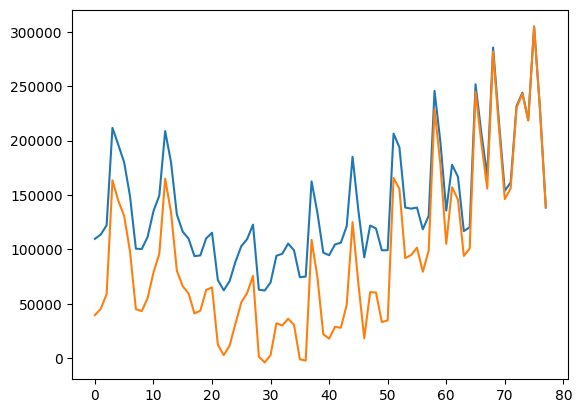

In [13]:
plt.plot(option_prices[:, -1, 0])
plt.plot(spark_spreads[:, -1, 0])

In [8]:
pd.DataFrame(option_prices[:, :, 0], index=simulation_dates, columns=maturity_dates).iloc[0:30]

,2024-06-01,2024-06-02,2024-06-03,2024-06-04,2024-06-05,2024-06-06,2024-06-07,2024-06-08,2024-06-09,2024-06-10,...,2024-08-01,2024-08-02,2024-08-03,2024-08-04,2024-08-05,2024-08-06,2024-08-07,2024-08-08,2024-08-09,2024-08-10
2024-05-25,55809.688978,57486.767756,59082.167217,60604.983117,62062.779437,63461.907432,64807.751554,66104.918396,67357.382551,68568.600113,...,105781.130047,106229.665413,106672.446590,107109.587625,107541.198962,107967.387601,108388.257253,108803.908483,109214.438843,109619.943007
2024-05-26,58485.925086,60212.592227,61855.674776,63423.902984,64924.784721,66364.751392,67749.323701,69083.262618,70370.697274,71615.230268,...,109677.499360,110134.824269,110586.260893,111031.926510,111471.934673,111906.395376,112335.415214,112759.097531,113177.542563,113590.847568
2024-05-27,67267.466678,68893.979093,70461.897679,71972.334824,73427.971233,74832.032913,76187.829439,77498.547632,78767.165816,79996.426053,...,118151.771991,118612.628744,119067.575236,119516.727988,119960.199870,120398.100257,120830.535189,121257.607512,121679.417014,122096.060558
2024-05-28,164171.855330,164659.603942,165250.049754,165920.236337,166651.216452,167427.911562,168238.484755,169073.678167,169926.244911,170790.496116,...,207325.698823,207824.840072,208318.313302,208806.202939,209288.591779,209765.561017,210237.190268,210703.557600,211164.739561,211620.811208
2024-05-29,145172.998364,145718.139883,146398.368167,147177.501103,148027.385464,148926.946313,149860.565146,150816.659535,151786.600413,152763.922503,...,191564.029007,192078.414450,192586.739167,193089.101893,193585.599077,194076.324940,194561.371542,195040.828841,195514.784749,195983.325192
2024-05-30,131004.475275,131413.351434,131994.085168,132701.674702,133499.173783,134358.984206,135261.019346,136190.714521,137137.465980,138093.503958,...,175695.105258,176188.605497,176676.205383,177158.004079,177634.098331,178104.582540,178569.548841,179029.087159,179483.285288,179932.228947
2024-05-31,98027.009783,98521.061846,99267.674239,100172.410211,101170.913584,102222.582968,103301.856481,104392.425810,105483.740478,106568.907436,...,144605.668891,145081.433458,145551.231187,146015.173371,146473.368099,146925.920386,147372.932290,147814.503031,148250.729092,148681.704331
2024-06-01,45490.849883,46936.243833,48646.614594,50365.245840,52027.638446,53618.427109,55136.957642,56587.195978,57974.357556,59303.710480,...,96853.085218,97285.197815,97711.513893,98132.156947,98547.246236,98956.896995,99361.220627,99760.324880,100154.314022,100543.288995
2024-06-02,0.000000,43866.617226,45506.695894,47363.081472,49193.507613,50945.721015,52611.467277,54194.352025,55701.041416,57138.552546,...,96503.357586,96950.061440,97390.706953,97825.425646,98254.344438,98677.585873,99095.268330,99507.506230,99914.410218,100316.087345
2024-06-03,0.000000,0.000000,55406.926535,56549.628049,58078.985561,59699.262002,61312.919077,62885.853271,64406.591645,65872.536830,...,107278.938697,107751.865237,108218.392971,108678.659890,109132.799199,109580.939550,110023.205266,110459.716541,110890.589642,111315.937085


In [ ]:
option_prices_lists = []
spark_spread_lists = []

# We will compute one option for each expiry date that we have
for i, date in enumerate(contract_dates):
    option_prices_list = []
    spark_spread_list = []
    
    # Compute delta_t in years (time difference between the Energy Payment date and delivery), taking into account the 1-day delivery delay
    if energy_payment_grouped_monthly:
        days_to_end_month = ((date + pd.offsets.MonthEnd(0)) - date).days
        delta_t = (days_to_end_month + energy_payment_delay - 1) / 365.25
    else:
        delta_t = (energy_payment_delay - 1) / 365.25
        
    # Compute time to expiry of the current option (in years), taking into account the 1-day delivery delay
    time_to_expiry = ((date - start_simulation_date).days + 1) / 365.25
    
    for j in range(nb_scenarios):
        # Load the power and gas prices
        power_price = power_prices_df.iloc[i, j]
        gas_price = gas_prices_df.iloc[i, j]
        
        # Compute the coefficients for the HRCO option
        # Note that, since delta_t is not constant but rather depends on the day of the month, these coefficients need to be dinamically computed for each option
        alpha = daily_volume
        beta = np.exp(-interest_rate * delta_t) * (daily_volume * heat_rate + start_charge)
        strike = np.exp(-interest_rate * delta_t) * (daily_volume * (heat_rate * gas_adder + VOM) + start_charge * gas_adder)
        
        # Add the spark spread to the list
        spark_spread_list.append(alpha * power_price - beta * gas_price - strike)

        # Create the option instance
        opt = SpreadOptionTwoAssets(
            type = "Call",
            underlying1 = power_price,
            underlying2 = gas_price,
            coef1 = alpha,
            coef2 = beta,
            strike = strike,
            time_to_expiry = time_to_expiry,
            volatility1 = power_vol, 
            volatility2 = gas_vol,
            correlation = power_gas_corr,
            rate = interest_rate
        )
         
        option_prices_list.append(opt.price())
    spark_spread_lists.append(spark_spread_list)
    option_prices_lists.append(option_prices_list)

In [13]:
spark_spread_df = pd.DataFrame(spark_spread_lists, index=contract_dates, columns=range(nb_scenarios))
option_prices_df = pd.DataFrame(option_prices_lists, index=contract_dates, columns=range(nb_scenarios))
payoff_df = spark_spread_df.copy().clip(lower=0)
time_value_df = option_prices_df.copy() - payoff_df.copy()

## Compute MtM

In [17]:
THIS NEED TO BE CHANGED COMPLETELY, 

WE NEED TO HAVE A MTM STARTING ON THE SIMULATION DATE, AND THEN WE SUM ALL THE OPTION PRICES THAT WE HAVE TO BE LIKE THE MTM 

WE ALSO NEED TO BE REMOVING ALL THE OPTIONS THAT MATURE

THINK ABOUT THIS AND HOW IT IS COMPUTED BEFORE, BECAUSE MAYBE WE WERE THINKING ABOUT IT WRONG

SyntaxError: invalid syntax (769172168.py, line 1)

The formula for computing the MtM from the buyer's perspective is:

$$
MtM = \sum_t^T e^{-r \times t} \times COP - \sum_n^N e^{-r \times n} \times MOP
$$

Where
- $t$ is each day of the contract,
- $COP$ is the computed option premium,
- $N$ is the number of months of the contract,
- $MOP$ is the monthly Option Premium,
- $t_n$ is the day in which the monthly Option Premium is paid.

This follow the rationale that the trader will only execute an option when the Spark Spread is positive (thus the max in the HRCO payoff), and he will pay each month the agreed Option Premium in the contract.

In [14]:
# Initialize the MtM df
mtm_df = pd.DataFrame(0, index=contract_dates, columns=range(nb_scenarios))

# Compute the discount factors for the HRCO Payoff
discount_factors_payoff = np.exp(-interest_rate * (contract_dates - start_simulation_date).days / 365.25)

# Add to the MtM the discounted payoffs
mtm_df += discount_factors_payoff.values[:, np.newaxis] * payoff_df

# Compute the discount factors for the optiom premium payments
discount_factors_premium = np.exp(-interest_rate * (option_premium_payment_dates - start_simulation_date).days / 365.25)

# Extend the option premium payments with 0 in the dates that are not paid (so that we can do a cumsum)
option_premium_payments = pd.Series(monthly_option_premium, index=option_premium_payment_dates, name="Premium").to_frame()
option_premium_payments = pd.merge(mtm_df.reset_index(), option_premium_payments.reset_index(), how="left", on="index")["Premium"].fillna(0)
option_premium_payments.index = contract_dates

# Substract from the MtM the discounted option premium payments
mtm_df -= option_premium_payments.values[:, np.newaxis]

# Finally, we do the cumsum of the mtm to have the real cumulative mtm of the buyer
mtm_df = mtm_df.cumsum()

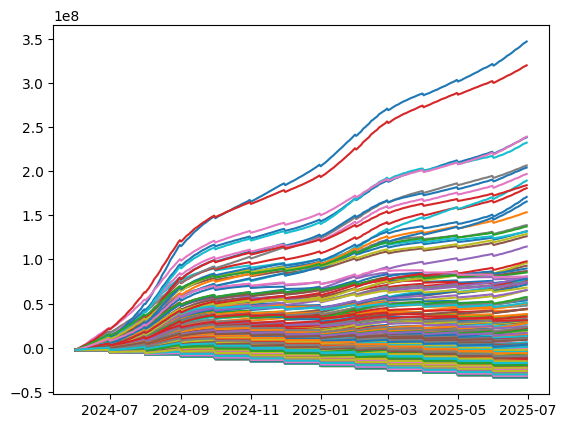

In [15]:
plt.plot(mtm_df)
plt.show()